# Unsupervised Phoneme Recognition

## Kyle Roth & Seong-Eun Cho

### MATH 402, Fall 2018

Transcription of spoken language is a difficult process. Field linguists spend their lives training their ear to catch small differences in sound, recording them in the International Phonetic Alphabet (IPA). Recorded audio has helped little. Automatic phonetic transcription has been attempted by [1], [2], and many others, but was limited to one language and didn’t use neural networks. [3] used temporal flow networks to achieve 80% accuracy, but on a dataset of only 37 words spoken over 2.5 hours. Their approach used an array of networks to estimate phonetic features and then predict phonemes. We feel that these approaches were limited by the lack of data and their specificity to one language. We will attempt this task using unsupervised learning, allowing us to learn on varied, extensive, unlabeled data.

For this task we use two data sources:

- scraped audio from talks in the general conference of the Church of Jesus Christ of Latter-Day Saints, and
- VoxCeleb, a corpus of interviews with celebrities from around the world.

In [1]:
# deals with audio
from scripts.prepare import split_audio as audio

# cleans up after conversion from .m4a
from scripts.prepare.voxceleb import convert
# deals with edge trimming
from scripts.prepare.voxceleb import edges
import scipy as sp
from scipy import signal
from IPython import display
from scipy.io import wavfile
from glob import glob
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm_notebook as tqdm
#from scripts.recognize.recognize import PhonemeSimilarity

## VoxCeleb data and General Conference data download and conversion

The bash commands in `voxceleb.sh` download VoxCeleb1 and VoxCeleb2 and perform conversion to .wav on VoxCeleb2 (natively .m4a).

```bash
./voxceleb.sh
```

On an 8th generation i5 processor the ffmpeg conversion took about 2 days.

The following function removes .m4a files and names the .wav files correctly after being converted by ffmpeg in `voxceleb.sh`.

In [50]:
convert.cleanup('/media/kylrth/KYLEBAK/data_project/data/vox2_dev')

### Properties of the data

This data was downloaded from http://www.robots.ox.ac.uk/~vgg/data/voxceleb/, and was formatted in the following way:

In [51]:
audio.get_properties('sample/00001.wav')


Input File     : 'sample/00001.wav'
Channels       : 1
Sample Rate    : 16000
Precision      : 16-bit
Duration       : 00:00:09.24 = 147841 samples ~ 693.005 CDDA sectors
File Size      : 296k
Bit Rate       : 256k
Sample Encoding: 16-bit Signed Integer PCM




The general conference data was scraped, downsampled, and formatted to .wav:

In [52]:
audio.get_properties('sample/2018-10-1010-russell-m-nelson-64k-eng.wav')


Input File     : 'sample/2018-10-1010-russell-m-nelson-64k-eng.wav'
Channels       : 1
Sample Rate    : 16000
Precision      : 16-bit
Duration       : 00:06:28.65 = 6218397 samples ~ 29148.7 CDDA sectors
File Size      : 12.4M
Bit Rate       : 256k
Sample Encoding: 16-bit Signed Integer PCM




## Cleaning the data

We perform the following preprocessing steps to the data:

- Split the audio into segments of five seconds
- Fragment trimming
- Noise reduction

### Splitting into segments

We believe shorter segments around 5 seconds will be optimal for training on this data with the model we will build next semester.

In [12]:
S = audio.SoundWave(*wavfile.read('sample/2018-10-1010-russell-m-nelson-64k-eng.wav'))
waves = S.split()

In [13]:
for w in waves[:10]:
    # print the length in seconds
    print('{:6.3f}'.format(len(w.samples) / w.rate), 's')

 2.688 s
 2.104 s
 5.007 s
 3.391 s
 1.498 s
 3.218 s
 0.618 s
 2.585 s
 1.142 s
 1.023 s


### Fragment trimming

To avoid training on partial phonemes, we trim all the bits of speech that occur separate from the main body of speech, on either end of the file. Below is an example.

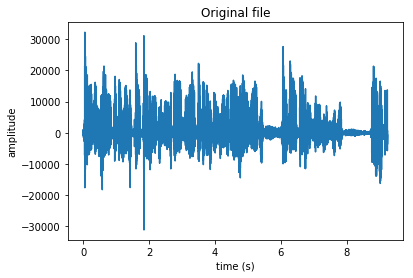

In [2]:
s = audio.SoundWave(*wavfile.read('sample/00001.wav'))
plt.figure()
plt.plot(np.arange(len(s.samples) / s.rate, step=1 / s.rate), s.samples)
plt.xlabel('time (s)')
plt.ylabel('amplitude')
plt.title('Original file')
plt.show()
display.Audio('sample/00001.wav')

Now here's the fixed version.

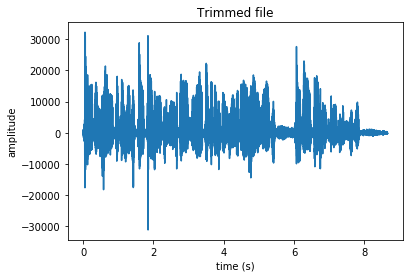

In [3]:
s = edges.fix('sample/00001.wav', burst_length=500, pause_length=200)
plt.figure()
plt.plot(np.arange(len(s.samples) / s.rate, step=1 / s.rate), s.samples)
plt.xlabel('time (s)')
plt.ylabel('amplitude')
plt.title('Trimmed file')
plt.show()
s.export('sample/00001_clean.wav')
display.Audio('sample/00001_clean.wav')

## Feature engineering

Since our objective is to take in an audio sample and output phonetic transcriptions, we had to come up with a way to embed each phoneme as an array in a specific vector space. We use the following methods to extract these features from the data:

- Discrete Fourier Transform (DFT)
- Spectral analysis
- Cepstral analysis
- Wavelets

### Discrete Fourier Transform and Spectral Analysis

From Wikipedia, we have gathered audio files of a person pronouncing each phoneme. Here, we pinpoint the exact timestamps at which the phoneme sound occurs from the phoneme audio and compare it to the occurrences of the respective phoneme from the data. We do this for the phonemes /b/, /f/, /n/, /æ/, and /i/. We take the DFT of these phonemes and compare them side by side. We also take the spectrum of the phonemes, which is simply the log of the absolute value of the DFT. We also compare the spectrum side by side. Doing this reveals that each of the phonemes show similar characteristics even when spoken by different speakers in the DFT space and spectrum space.

In [4]:
# read the Wikipedia audio
rate, wave = wavfile.read("ipa/16k-wav/pulmonic_consonant/Voiced_bilabial_plosive.wav")
B = audio.SoundWave(rate, wave[3079:4491])
rate, wave = wavfile.read("ipa/16k-wav/pulmonic_consonant/Voiceless_bilabial_fricative.wav")
F = audio.SoundWave(rate, wave[3465:7547])
rate, wave = wavfile.read("ipa/16k-wav/pulmonic_consonant/Alveolar_nasal.wav")
N = audio.SoundWave(rate, wave[4131:8690])
rate, wave = wavfile.read("ipa/16k-wav/vowel/Near-open_front_unrounded_vowel.wav")
AE = audio.SoundWave(rate, wave)
rate, wave = wavfile.read("ipa/16k-wav/vowel/Close_front_unrounded_vowel.wav")
EE = audio.SoundWave(rate, wave)

# read the audio from President Nelson
rate, wave = wavfile.read("sample/2018-10-1010-russell-m-nelson-64k-eng.wav")
eng_B1 = audio.SoundWave(rate, wave[27701:28662])
eng_B2 = audio.SoundWave(rate, wave[1298209:1299154])
eng_F = audio.SoundWave(rate, wave[1349373:1351894])
eng_N = audio.SoundWave(rate, wave[1451719:1453231])
eng_AE = audio.SoundWave(rate, wave[1526024:1527631])
eng_EE = audio.SoundWave(rate, wave[1584120:1586152])

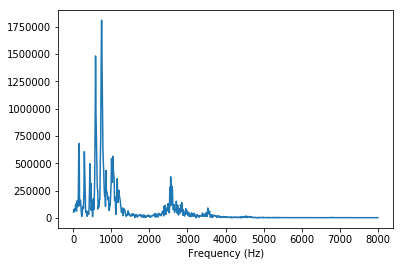

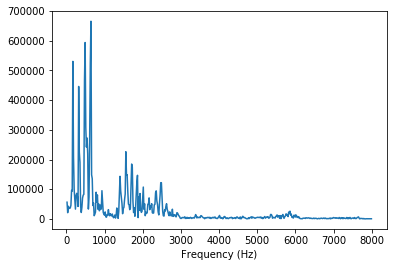

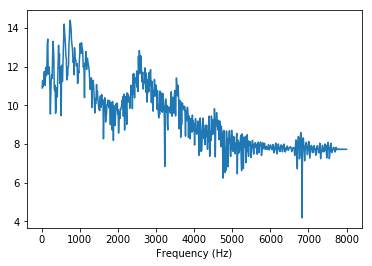

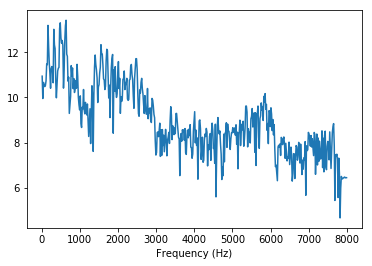

In [5]:
B.plot(mode="dft")
eng_B2.plot(mode="dft")
B.plot(mode="spectrum")
eng_B2.plot(mode="spectrum")

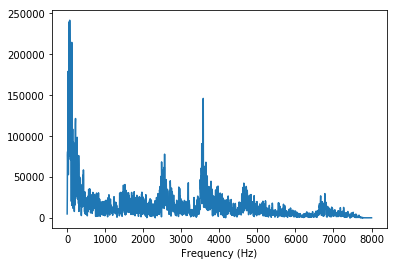

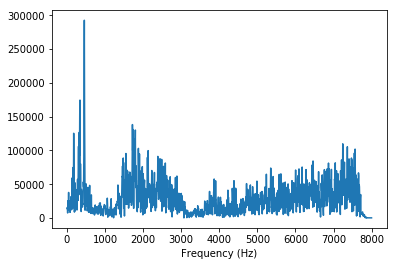

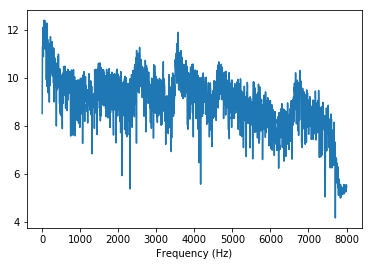

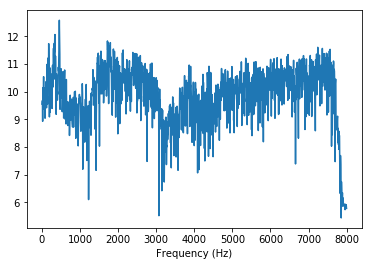

In [6]:
F.plot(mode="dft")
eng_F.plot(mode="dft")
F.plot(mode="spectrum")
eng_F.plot(mode="spectrum")

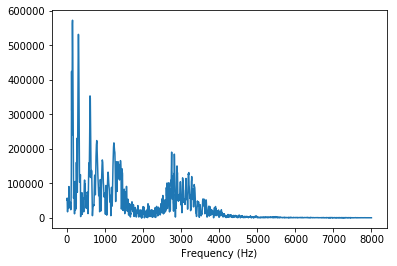

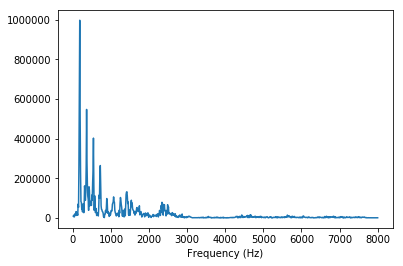

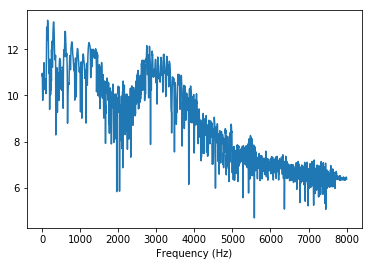

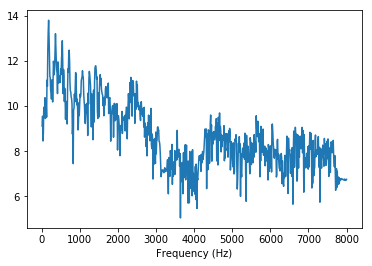

In [7]:
N.plot(mode="dft")
eng_N.plot(mode="dft")
N.plot(mode="spectrum")
eng_N.plot(mode="spectrum")

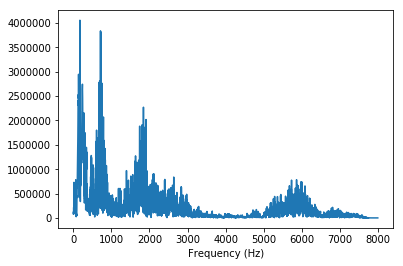

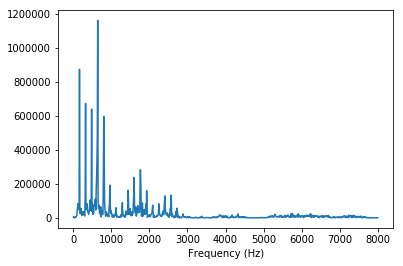

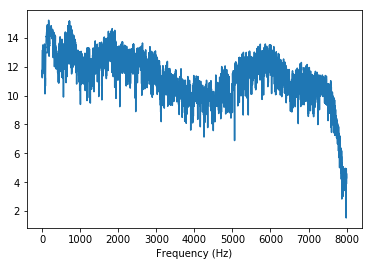

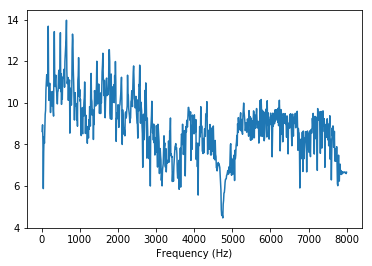

In [8]:
AE.plot(mode="dft")
eng_AE.plot(mode="dft")
AE.plot(mode="spectrum")
eng_AE.plot(mode="spectrum")

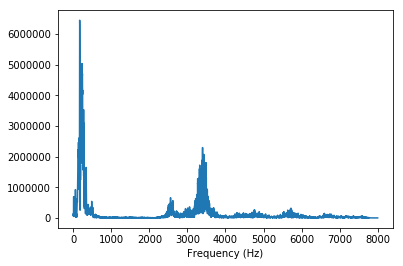

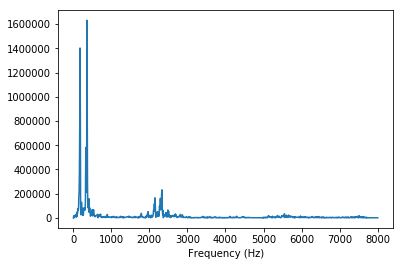

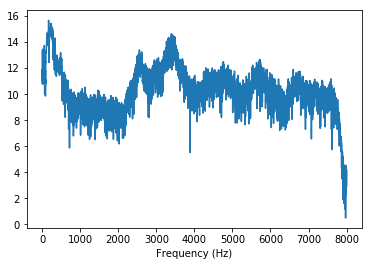

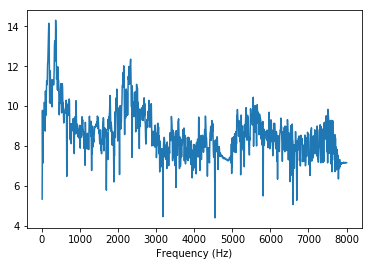

In [9]:
EE.plot(mode="dft")
eng_EE.plot(mode="dft")
EE.plot(mode="spectrum")
eng_EE.plot(mode="spectrum")

### Wavelets

Speech recognition using wavelets has been done previously, [with moderate success](https://www.clear.rice.edu/elec431/projects97/Dynamic/main.html). Here we use the Discrete Wavelet Transform to represent the audio with less detail than before.

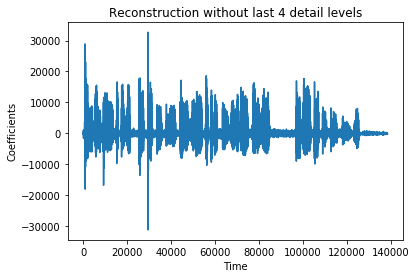

In [10]:
s.plot(mode='db4', wavelet_idx=4)  # leave off last 4 layers of detail
s.export('sample/00001_wavelet.wav')
display.Audio('sample/00001_wavelet.wav')

## Spectrogram

Spectrograms are incredibly useful for visualizing audio recodings of human speech because they capture the nature of phoneme frequencies as a visual graph. Spectrograms are computed in the following way:

A small window of a specified time frame (defaulted to 0.03 seconds) is initialized at the beginning of the audio sample. The spectrum $log(|DFT(x)|)$ of the audio in that window is computed and saved. This window slides across the audio sample with a small amount of overlap from the previous window (defaulted to 0.01 seconds). This continues on until the entire sample has been covered, and is returned.

We transpose the returned spectrogram before plotting, since each element of the array corresponds to the spectrum of a window. We plot the spectrogram using a meshgride of time (x) vs frequency (y) using a heat map.

<Figure size 720x360 with 0 Axes>

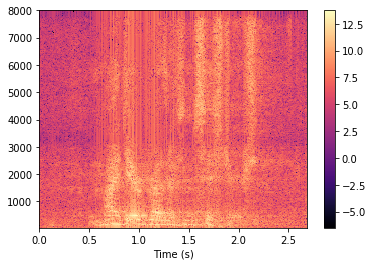

In [15]:
# spec = waves[0].spectrogram(time_frame=0.03, overlap_frame=0.01)
# d1, d2 = spec.shape
# rate = S.rate
# N = int(rate * 0.03)
# y = np.linspace(1, N, N)
# y = y * rate / N
# x = np.linspace(0, len(waves[0].samples)/rate, d1)
# X, Y = np.meshgrid(x, y[:N//2])

fig = plt.figure(figsize=(10,5))
waves[0].plot(mode='spectrogram')
plt.show()

## Phoneme boundary detection

We attempt various methods to detect boundaries between phonemes. The first involves finding the locations where the spectrum values have changed the most. We do that using the following function.

In [65]:
def find_key(dictionary, value):
    """Finds the first key corresponding to `value` in the dictionary."""
    for k, v in dictionary.items():
        if v == value:
            return k


def find_n_fastest(sound, n, feature='cepstrum'):
    """Find the n positions where the given feature changes the fastest."""
    
    if feature == 'cepstrum':
        feature = sound.cepstrum()
    elif feature == 'spectrogram':
        feature = sound.spectrogram()
    elif feature == 'dft':
        feature = sound.dft()
    
    prev = None
    fastest = {}
    
    for idx, val in enumerate(feature):
        if 0 < idx <= n:
            # the first n samples are loaded into the `fastest` dictionary
            fastest[idx] = np.linalg.norm(val - prev)
        elif prev is not None:
            # every sample after n is compared with those in the dictionary
            diff = np.linalg.norm(val - prev)
            current_min = min(fastest.values())
            if diff > current_min:
                # replace the worst best entry with the new one
                del fastest[find_key(fastest, current_min)]
                fastest[idx] = diff

        prev = val
    
    return fastest

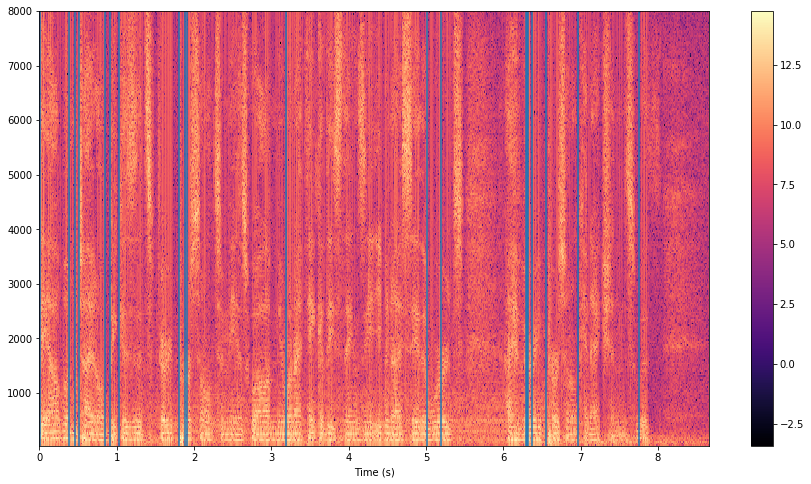

DFT	Spec	Ceps
0.04	0.39	0.39
0.05	0.46	0.46
0.06	0.51	0.51
0.08	0.85	0.85
0.09	0.91	0.91
0.58	1.03	1.03
0.59	1.80	1.80
0.95	1.89	1.89
1.60	1.91	1.91
1.61	3.19	3.19
1.62	4.46	4.46
1.82	5.01	5.01
1.83	5.15	5.15
1.84	5.19	5.19
1.85	6.29	6.29
3.49	6.32	6.32
4.86	6.37	6.37
6.29	6.55	6.55
6.37	6.96	6.96
6.38	7.75	7.75


In [66]:
quantity = 20
spec = list(find_n_fastest(s, quantity, 'spectrogram').keys())

# plot the spectrogram
s.plot(mode='spectrogram')

# add vertical lines where the spectrum changed the most from one window to the next
for point in spec:
    plt.axvline(x=point * 0.01)
plt.show()

# do the same with DFT and cepstrum, and compare
dft = list(find_n_fastest(s, quantity, 'dft').keys())
cep = list(find_n_fastest(s, quantity, 'cepstrum').keys())

print('DFT\tSpec\tCeps')
for i in range(quantity):
    print('{:.2f}\t{:.2f}\t{:.2f}'.format(dft[i] * 0.01, cep[i] * 0.01, cep[i] * 0.01))

Upon inspection, there are several points that seem to be consistent with boundaries between morphemes. More analysis needs to be performed.

# Phoneme detection

As we have seen from the spectral analysis, one naïve way of embedding phonemes is by taking the spectrum of it. We then hypothesized that if each phoneme has similar values in the spectrum space, then by taking the model phoneme and taking the L2 norm difference with each window of sample of our data will reveal that the places where the phoneme occurs in our sample will have a very small norm difference. We used this idea to identify 10 smallest norm difference between a window of sample and the model phoneme for /f/.

In [67]:
rate, wave = wavfile.read("ipa/16k-wav/pulmonic_consonant/Voiceless_labiodental_fricative.wav")

In [68]:
F = wave[3518:7942]
F_dft = np.log(np.abs(sp.fft(F)))
n = len(F_dft)
F_dft = F_dft[:n//2]
# Resample so that the domain of the model phoneme matches the domain of the window
F_dft_resampled = signal.resample(F_dft, 240)

/Users/Seong-EunCho/anaconda/lib/python3.6/site-packages/scipy/signal/signaltools.py:2223: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
/Users/Seong-EunCho/anaconda/lib/python3.6/site-packages/scipy/signal/signaltools.py:2225: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
/Users/Seong-EunCho/anaconda/lib/python3.6/site-packages/scipy/signal/signaltools.py:2230: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this 

In [69]:
def find_dft_norm(samples, rate, phoneme, time_frame=0.03, overlap_frame=0.01):
        window = int(rate * time_frame)
        stride = int(rate * overlap_frame)
        i = 0
        s = []
        while True:
            j = i + window
            if j >= len(samples):
                break
            spectrum = np.log(np.abs(sp.fft(samples[i:j])[:window//2]))
            dist = np.linalg.norm(spectrum - phoneme)
            s.append(dist)
            i += stride

        return np.array(s)

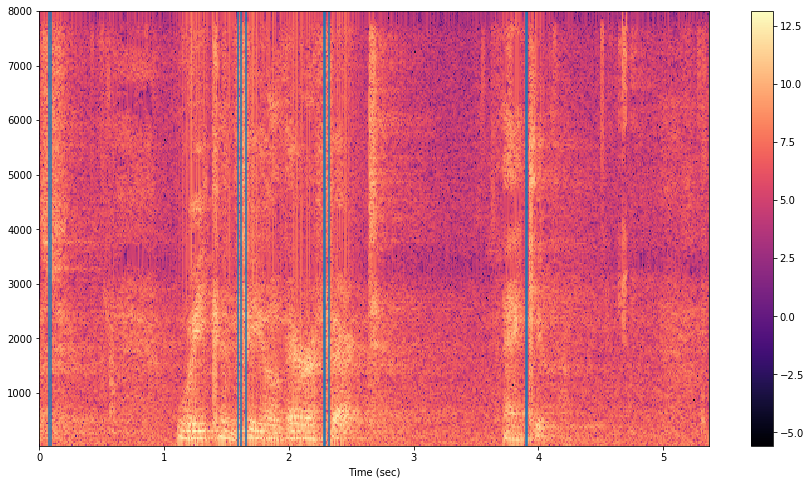

In [70]:
rate, sample = wavfile.read("sample/sample2.wav")
wave = audio.SoundWave(rate, sample)
s = wave.spectrogram()
norms = find_dft_norm(wave.samples, rate, F_dft_resampled)
small_norm = np.sort(norms)[10]
indices = np.where(norms < small_norm)

d1, d2 = s.shape
N = int(rate * 0.03)
y = np.linspace(1, N, N)
y = y * rate / N
x = np.linspace(0, len(wave.samples)/rate, d1)
X, Y = np.meshgrid(x, y[:N//2])

fig = plt.figure()
plt.pcolormesh(X, Y, s.T, cmap='magma')
plt.colorbar()
plt.xlabel("Time (sec)")
for j in indices[0]:
    plt.axvline(x=j*0.01)
plt.show()

From the result above, we see that the 10 lowest norm difference occurs in 4 distinct places. In this audio sample, the speaker says "We can feel their effect, thank you.". The first occurrence near 0 is a trailing /s/ sound from the previous audio which is a fricative like the /f/. The second and third occurrences at around 1.5 and 2.2 seconds respectively, is precisely when the speaker says /f/ in the words "feel" and "effect". The last occurrence near 4 seconds seems to be an outlier. From these results, we can see that even with a naïve approach, we can identify the characteristics for phonemes.

## Phoneme detection with derivatives

We want to find a sequence of time stamps which divide the audio into phonemes. We'd like to test the hypothesis that phoneme boundaries occur where the change in certain features is most acute; that is, where the derivative along some dimension of the feature space has the greatest magnitude.

We don't have the expertise to mark phoneme boundaries by hand, and we feel that even expert human judgment is prone to produce errors. Thus we judge the output of various attempts simply by checking whether the division is reasonable to the human ear.

In [73]:
s = audio.SoundWave(*wavfile.read('sample/00001_clean.wav'))
display.Audio('sample/00001_clean.wav')

In [74]:
def find_key(dictionary, value):
    """Finds the first key corresponding to `value` in the dictionary."""
    for k, v in dictionary.items():
        if v == value:
            return k


def find_n_fastest(sound, n, feature='cepstrum'):
    """Find the n positions where the given feature changes the fastest."""
    
    if feature == 'cepstrum':
        feature = sound.cepstrum()
    elif feature == 'spectrogram':
        feature = sound.spectrogram()
    elif feature == 'dft':
        feature = sound.dft()
    
    prev = None
    fastest = {}
    
    for idx, val in enumerate(feature):
        if 0 < idx <= n:
            # the first n samples are loaded into the `fastest` dictionary
            fastest[idx] = np.linalg.norm(val - prev)
        elif prev is not None:
            # every sample after n is compared with those in the dictionary
            diff = np.linalg.norm(val - prev)
            current_min = min(fastest.values())
            if diff > current_min:
                # replace the worst best entry with the new one
                del fastest[find_key(fastest, current_min)]
                fastest[idx] = diff

        prev = val
    
    return fastest

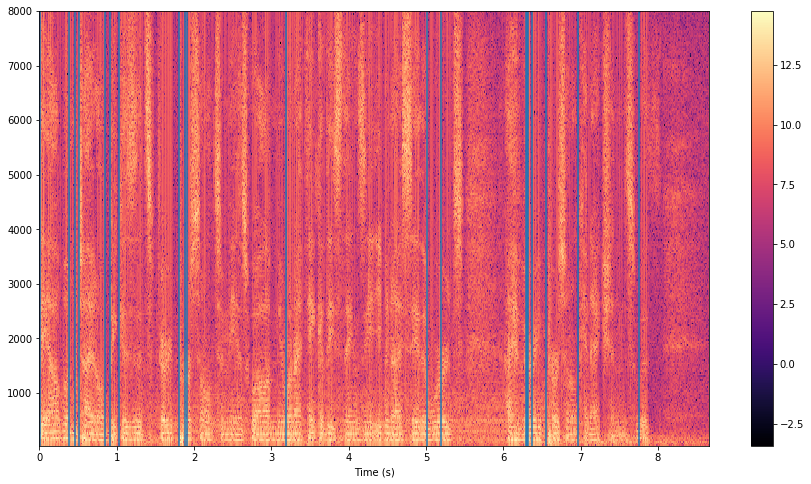

DFT	Spec	Ceps
0.04	0.39	0.39
0.05	0.46	0.46
0.06	0.51	0.51
0.08	0.85	0.85
0.09	0.91	0.91
0.58	1.03	1.03
0.59	1.80	1.80
0.95	1.89	1.89
1.60	1.91	1.91
1.61	3.19	3.19
1.62	4.46	4.46
1.82	5.01	5.01
1.83	5.15	5.15
1.84	5.19	5.19
1.85	6.29	6.29
3.49	6.32	6.32
4.86	6.37	6.37
6.29	6.55	6.55
6.37	6.96	6.96
6.38	7.75	7.75


In [75]:
quantity = 20
spec = list(find_n_fastest(s, quantity, 'spectrogram').keys())

# plot the spectrogram
s.plot(mode='spectrogram')

# add vertical lines where the spectrum changed the most from one window to the next
for point in spec:
    plt.axvline(x=point / 100)
plt.show()

# do the same with DFT and cepstrum, and compare
dft = list(find_n_fastest(s, quantity, 'dft').keys())
cep = list(find_n_fastest(s, quantity, 'cepstrum').keys())

print('DFT\tSpec\tCeps')
for i in range(quantity):
    print('{:.2f}\t{:.2f}\t{:.2f}'.format(dft[i] * 0.01, cep[i] * 0.01, cep[i] * 0.01))

## Embedding spaces

For a set $\Omega$ of objects (e.g. audio, images, or text), an **embedding space** $(V,F)$ is defined by a metric space $V$ and an invertible function $F:\Omega\rightarrow V$ that maps objects from $\Omega$ to the vector space $V$. The goal is to "embed" these objects in an $n$-dimensional space where metric distance and vector addition become meaningful in some way.

With phonemes, the ideal would for distance to correlate with phonetic differences between two phonemes. In addition, meaningful vector addition would imply the following illustrative example:

$\qquad F(\text{/v/}) - F(\text{/f/}) + F(\text{/p/}) \approx F(\text{/b/})$.

(The difference between /v/ and /f/ is voicing, and when voicing is added to /p/ the result is /b/.)

Finding such a function $F$ is extremely valuable in creating a loss function for unsupervised phonetic transcription, as will be explained later on.

### The optimization problem

The following is a summary explanation of the concepts found in [3].

If each object can be represented as a vector $\mathbf x\in\mathbb R^n$, we can formulate finding the embedding function as an optimization problem over the space $M_n$ of matrices of size $n\times n$. If $x,y\in\mathbb R^n$ and $A\in M_n$ such that $A\succeq 0$, define the following distance metric:

$d_A(x,y)=||x-y||_A=\sqrt{(x-y)^\top A(x-y)}$.

In addition, let $S$ be a set of pairs such that for each pair $(x_i,x_j)\in S$ it is known that $x_i$ is similar to $x_j$. Similarly, let $D$ be a set of pairs such that for each pair $(x_i,x_j)\in D$ it is known that $x_i$ is dissimilar to $x_j$. Then the optimal embedding function is $A^{1/2}$, where $A$ is the solution to the following optimization problem:

$\qquad\min_A\sum_{(x_i,x_j)\in S}||x_i-x_j||_A^2$,

$\qquad\text{subject to }\sum_{(x_i,x_j)\in D}||x_i-x_j||_A\geq 1$,

$\qquad\qquad\qquad A\succeq 0$.

We can use gradient descent (or stochastic gradient descent if $S$ and $D$ are large) to optimize $A$. The algorithm is described in detail in [3].

[3] Xing, et al. "Distance metric learning, with application to clustering with side-information", UC Berkeley, 2003.

In [76]:
# need to add some explanation of the algorithm here

Here is some example code that will predict the phoneme found in the sample:

In [ ]:
# if `phonemes` is a dictionary mapping phoneme characters to lists of SoundWave objects,
# the following will work. (work in progress)
rate, wave = wavfile.read("ipa/16k-wav/pulmonic_consonant/Voiced_bilabial_plosive.wav")
sample = audio.SoundWave(rate, wave[3079:4491])
recognizer = PhonemeSimilarity(phonemes)
print(recognizer.predict(sample))  # should print 'b'

/Users/Seong-EunCho/anaconda/lib/python3.6/site-packages/scipy/signal/signaltools.py:2223: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
/Users/Seong-EunCho/anaconda/lib/python3.6/site-packages/scipy/signal/signaltools.py:2225: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
/Users/Seong-EunCho/anaconda/lib/python3.6/site-packages/scipy/signal/signaltools.py:2230: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this 

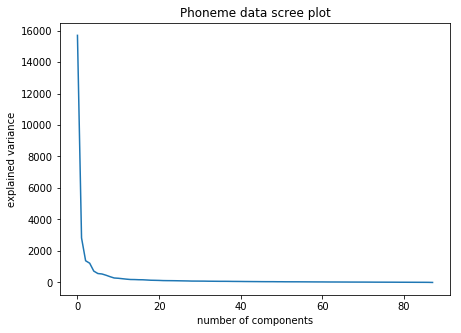

In [17]:
import os
class PCA:
    def __init__(self, X, y=None, s=None):
        self.X = X - X.mean(axis=0)
        self.y = y
        if s == None:
            n, d = X.shape
            s = d
        U, sig, Vh = np.linalg.svd(self.X)
        self.sig = sig[:s]**2
        self.Vh = Vh[:s]
        self.a = self.transform(X)
        self.proj_X = self.project(X)
    
    def transform(self, x):
        return self.Vh@x.T
    
    def project(self, x):
        return self.Vh.T@self.a

def get_phoneme_data(phonemes=['f', 's', 'g', 't', 'p', 'schwa', 'ae', 'i', 'a']):
    phone_data = []
    phoneme_dict = {}
    for i, p in enumerate(phonemes):
        path = "ipa/"
        for f in os.listdir(path + p):
            fname = path + p + '/' + f
            rate, sample = wavfile.read(fname)
            n = len(sample)
            wave_spec = np.log(np.abs(sp.fft(sample))[:n//2])
            wave_spec = signal.resample(wave_spec, 240)
            phoneme_dict[i] = p
            phone_data.append(np.hstack([i, wave_spec]))

    phone_data = np.array(phone_data)
    X = phone_data[:, 1:]
    y = phone_data[:, 0]
    return X, y, phoneme_dict

X, y, phoneme_dict = get_phoneme_data()
phoneme_dict[5] = 'ɘ'
phoneme_dict[6] = 'æ'
phoneme_dict
pca = PCA(X)
n, d = X.shape

fig = plt.figure(figsize=(7, 5))
plt.plot(np.arange(n), pca.sig)
plt.xlabel("number of components")
plt.ylabel("explained variance")
plt.title("Phoneme data scree plot")
plt.show()

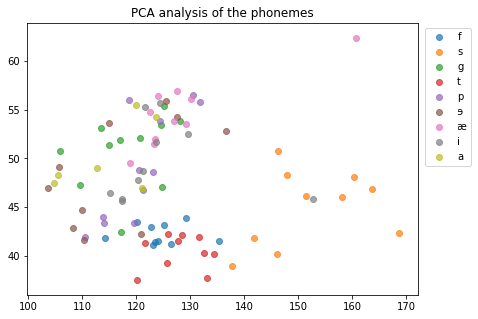

In [18]:
fig = plt.figure(figsize=(7, 5))
pca2 = PCA(X, y=y, s=2)
A = np.vstack([pca2.a, pca2.y])
for i in np.unique(y):
    curr_a = A.T[A[2] == i][:, :2]
    plt.scatter(curr_a[:, 0], curr_a[:, 1], label=phoneme_dict[i], alpha=0.7)
plt.legend(bbox_to_anchor=(1.15, 1))
plt.title("PCA analysis of the phonemes")
plt.show()

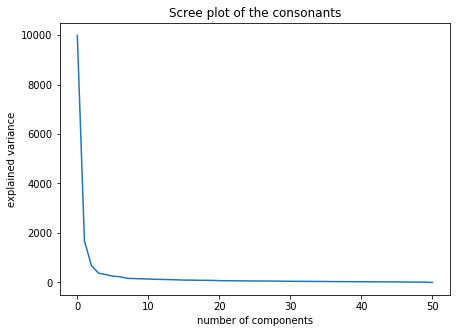

In [20]:
X_c = X[y < 5]
y_c = y[y < 5]
pca_c = PCA(X_c)
n, d = X_c.shape

fig = plt.figure(figsize=(7, 5))
plt.plot(np.arange(n), pca_c.sig)
plt.xlabel("number of components")
plt.ylabel("explained variance")
plt.title("Scree plot of the consonants")
plt.show()

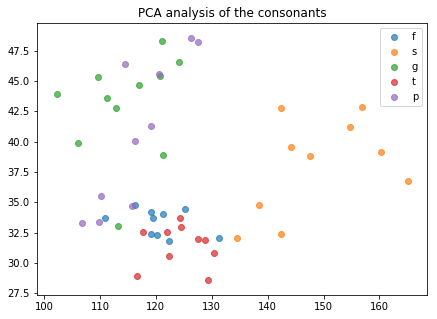

In [81]:
fig = plt.figure(figsize=(7, 5))
pca2_c = PCA(X_c, y=y_c, s=2)
A = np.vstack([pca2_c.a, pca2_c.y])
for i in np.unique(y_c):
    curr_a = A.T[A[2] == i][:, :2]
    plt.scatter(curr_a[:, 0], curr_a[:, 1], label=phoneme_dict[i], alpha=0.7)
plt.legend(bbox_to_anchor=(1, 1))
plt.title("PCA analysis of the consonants")
plt.show()

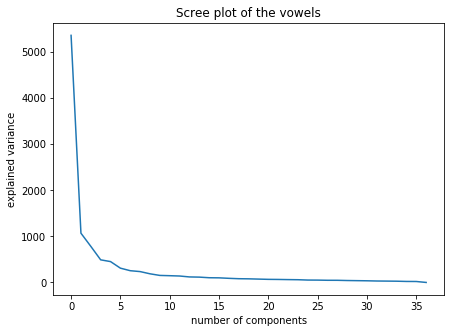

In [28]:
X_v = X[y >= 5]
y_v = y[y >= 5]
pca_v = PCA(X_v)
n, d = X_v.shape

fig = plt.figure(figsize=(7, 5))
plt.plot(np.arange(n), pca_v.sig)
plt.xlabel("number of components")
plt.ylabel("explained variance")
plt.title("Scree plot of the vowels")
plt.show()

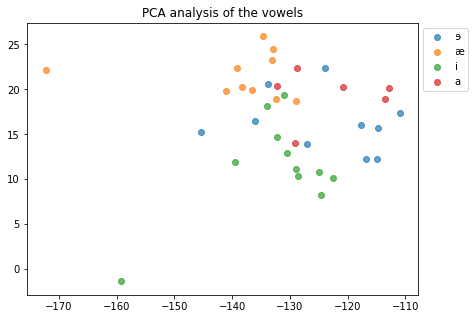

In [83]:
fig = plt.figure(figsize=(7, 5))
pca2_v = PCA(X_v, y=y_v, s=2)
A = np.vstack([pca2_v.a, pca2_v.y])
for i in np.unique(y_v):
    curr_a = A.T[A[2] == i][:, :2]
    plt.scatter(curr_a[:, 0], curr_a[:, 1], label=phoneme_dict[i], alpha=0.7)
plt.legend(bbox_to_anchor=(1, 1))
plt.title("PCA analysis of the vowels")
plt.show()

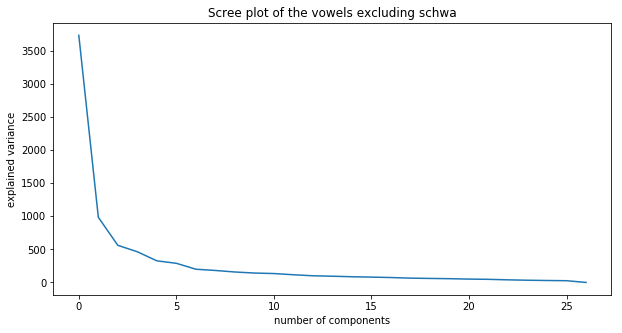

In [84]:
X_s = X[y > 5]
y_s = y[y > 5]
pca_s = PCA(X_s)
n, d = X_s.shape

fig = plt.figure(figsize=(10, 5))
plt.plot(np.arange(n), pca_s.sig)
plt.xlabel("number of components")
plt.ylabel("explained variance")
plt.title("Scree plot of the vowels excluding schwa")
plt.show()

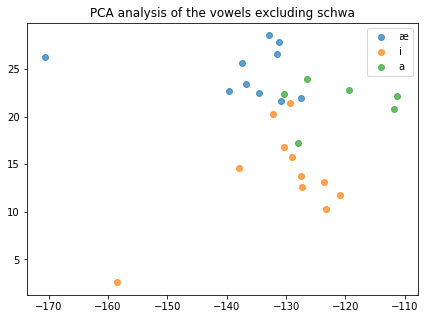

In [85]:
fig = plt.figure(figsize=(7, 5))
pca2_s = PCA(X_s, y=y_s, s=2)
A = np.vstack([pca2_s.a, pca2_s.y])
for i in np.unique(y_s):
    curr_a = A.T[A[2] == i][:, :2]
    #curr_a = curr_a[curr_a[:, 0] > -150]
    plt.scatter(curr_a[:, 0], curr_a[:, 1], label=phoneme_dict[i], alpha=0.7)
plt.legend(bbox_to_anchor=(1, 1))
plt.title("PCA analysis of the vowels excluding schwa")
plt.show()

In [22]:
def interpolation_data():
    path = "ipa/interpolate/audio"
    data = []
    for f in os.listdir(path):
        if f == ".DS_Store": continue
        fname = path + '/' + f
        rate, sample = wavfile.read(fname)
        n = len(sample)
        wave_spec = np.log(np.abs(sp.fft(sample))[:n//2])
        wave_spec = signal.resample(wave_spec, 240)
        data.append(wave_spec)
        
    return np.array(data)

interp = interpolation_data()

/Users/Seong-EunCho/anaconda/lib/python3.6/site-packages/scipy/signal/signaltools.py:2223: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
/Users/Seong-EunCho/anaconda/lib/python3.6/site-packages/scipy/signal/signaltools.py:2225: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
/Users/Seong-EunCho/anaconda/lib/python3.6/site-packages/scipy/signal/signaltools.py:2230: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this 

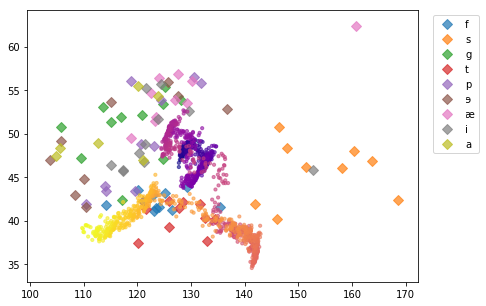

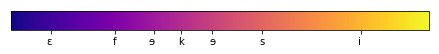

In [27]:
import matplotlib as mpl

A_ = pca2.transform(interp)
z = np.arange(A_.shape[1])
scaled_z = z / z.ptp()
fig = plt.figure(figsize=(7,5))
cmap = plt.cm.plasma
colors = cmap(scaled_z)

A = np.vstack([pca2.a, pca2.y])

for i in np.unique(y):
    curr_a = A.T[A[2] == i][:, :2]
    plt.scatter(curr_a[:, 0], curr_a[:, 1], label=phoneme_dict[i], alpha=0.7, s=50, marker="D")
'''
for i in np.unique(y):
    curr_a = A.T[A[2] == i][:, :2]
    hull = sp.spatial.ConvexHull(curr_a)
    plt.fill(curr_a[hull.vertices, 0], curr_a[hull.vertices, 1], alpha=0.5, label=phoneme_dict[i])
'''
plt.legend(bbox_to_anchor=(1.17, 1))


plt.scatter(A_[0], A_[1], alpha=0.6, color=colors, s=10)
plt.show()

fig, ax = plt.subplots(figsize=(7.5, 0.7))
fig.subplots_adjust(bottom=0.5)
bounds = [9.7, 24.9, 34.2, 40.7, 48.1, 60, 83.7]
norm = mpl.colors.Normalize(vmin=0, vmax=100)
#norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                ticks=bounds,
                                orientation='horizontal')
cb1.ax.set_xticklabels(['ɛ ', 'f', 'ɘ ', 'k', 'ɘ', 's', 'i '])
plt.show()